In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

import matplotlib.pyplot as plt
import psycopg2
import numpy as np
import sklearn
import requests
import scipy
import statistics

Populating the interactive namespace from numpy and matplotlib


In [2]:
conn = psycopg2.connect(database="delay", user="nikita")
conn.autocommit = True

In [3]:
line, way = 95, 2

cur = conn.cursor()
cur.execute("SELECT * FROM traject WHERE line='%i' AND way=%i ORDER BY id;" % (line, way))
data = cur.fetchall()

In [4]:
from collections import namedtuple
Traject = namedtuple("Traject", ('id', 'line', 'way', 'timestamps', 'start'))
models = [Traject(*row) for row in data]

In [5]:
stib_stops = requests.get("https://stib-mivb-api.herokuapp.com/network/line/%s/%s" % (line, way)).json()['stops']
len_stops = len(max(models, key=lambda x: len(x.timestamps)).timestamps)
assert len(stib_stops) == len_stops

In [6]:
vectors = []
for model in models:
    vector = [np.nan] * (len_stops - 1)
    
    for i in range(len_stops - 1):
        try:
            vector[i] = (model.timestamps[i + 1] - model.timestamps[i]).total_seconds()
        except (IndexError, TypeError):
            vector[i] = np.nan
    vectors.append(vector)

vectors = np.array(vectors)

In [7]:
# Remove vectors with too much NaN
bools = np.apply_along_axis(lambda x: len(list(filter(lambda y: np.isnan(y) ,x))) < 18, 1 , vectors)
good_vectors = vectors[bools]
good_vectors = vectors

In [8]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values="NaN", strategy='mean', axis=0)
imputed_vectors = imputer.fit_transform(good_vectors)

# Split the vectors in 2: features are v[:12] and targets are v[12:]
X, Y = imputed_vectors[:,:12], imputed_vectors[:,12:]

from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [9]:
from sklearn.neighbors import KNeighborsRegressor

In [10]:
def score_distance(diff):
    return np.linalg.norm(diff)

In [11]:
def model_mean(errors):
    return np.mean(errors)

# Comparons avec la STIB

In [12]:
knn = KNeighborsRegressor(n_neighbors=376, n_jobs=-1, weights="distance").fit(X_train, Y_train)
predictions = knn.predict(X_test)

In [13]:
stib_errors = []
knn_errors = []
a = []
for prediction, features, expected in zip(predictions, X_test, Y_test):
    indexes = np.where((X == features).all(axis=1))[0]
    if len(indexes) == 1:
        index = indexes[0]
        if index > 3 :#and not np.array_equal(expected,prediction):
            stib = np.mean(Y[index-3:index], axis=0)
            stib_errors.append(score_distance(expected - stib))
            knn_errors.append(score_distance(expected - prediction))

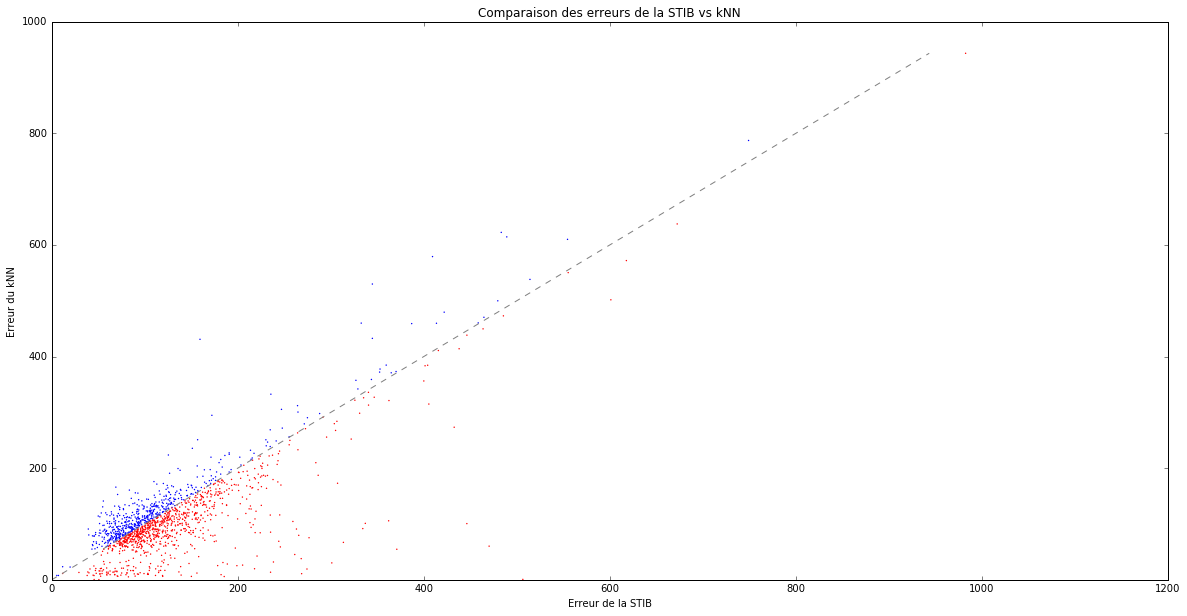

In [14]:
colors = ["red" if k < s else "blue" for s, k in zip(stib_errors, knn_errors)]
plt.scatter(stib_errors, knn_errors, s=2, c=colors, edgecolors='none')
m = min(max(stib_errors), max(knn_errors))
plt.plot([0, m], [0, m], linestyle="dashed", color="gray")
plt.title("Comparaison des erreurs de la STIB vs kNN")
plt.xlabel("Erreur de la STIB")
plt.ylabel("Erreur du kNN")
plt.xlim(xmin=0)
plt.ylim(ymin=0);

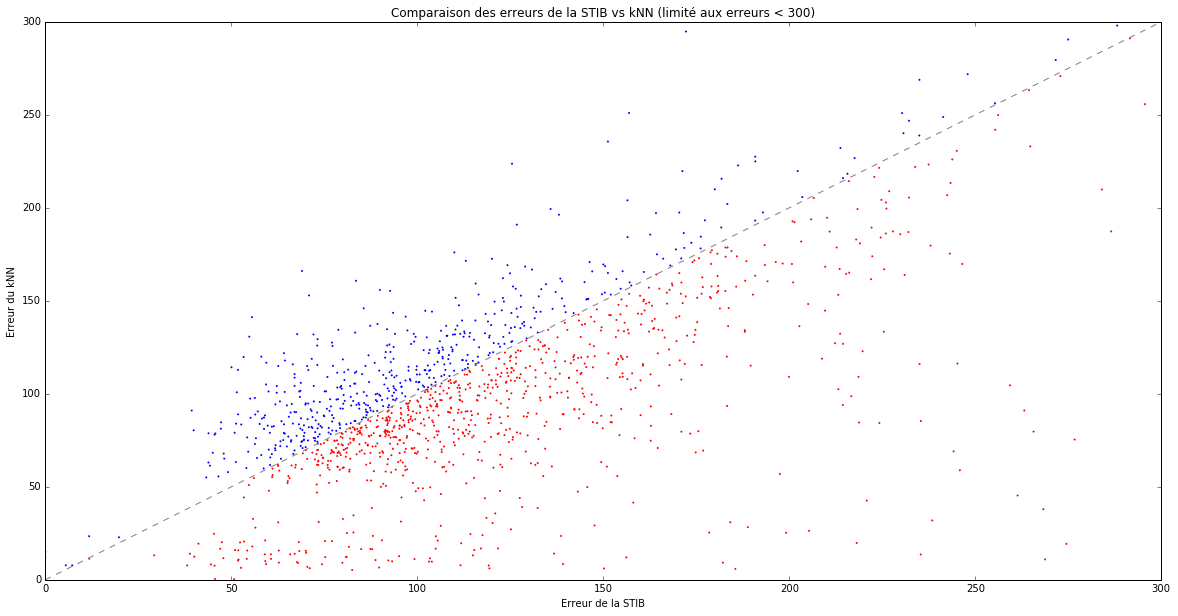

In [15]:
colors = ["red" if k < s else "blue" for s, k in zip(stib_errors, knn_errors)]
plt.scatter(stib_errors, knn_errors, s=4, c=colors, edgecolors='none')
m = min(max(stib_errors), max(knn_errors))
plt.plot([0, m], [0, m], linestyle="dashed", color="gray")
plt.title("Comparaison des erreurs de la STIB vs kNN (limité aux erreurs < 300)")
plt.xlabel("Erreur de la STIB")
plt.ylabel("Erreur du kNN")
plt.xlim(0,300)
plt.ylim(0,300);

In [16]:
knn_better = [k < s for s, k in zip(stib_errors, knn_errors)]

kkn_better_percent = len([x for x in knn_better if x]) / len(knn_better)
print("Knn est meilleur dans {:.2%}% des cas".format(kkn_better_percent))

Knn est meilleur dans 63.39%% des cas


In [17]:
knn1_better = [k * 1.5 < s for s, k in zip(stib_errors, knn_errors)]

kkn1_better_percent = len([x for x in knn1_better if x]) / len(knn1_better)
print("Knn est 1.5x meilleur dans {:.2%}% des cas".format(kkn1_better_percent))

Knn est 1.5x meilleur dans 17.97%% des cas


In [18]:
knn2_better = [k*2 < s for s, k in zip(stib_errors, knn_errors)]

kkn2_better_percent = len([x for x in knn2_better if x]) / len(knn2_better)
print("Knn est 2x meilleur dans {:.2%}% des cas".format(kkn2_better_percent))

Knn est 2x meilleur dans 11.53%% des cas


In [19]:
knn2_worst = [s*2 < k for s, k in zip(stib_errors, knn_errors)]

knn2_worst_percent = len([x for x in knn2_worst if x]) / len(knn2_worst)
print("Knn est 2x pire dans {:.2%}% des cas".format(knn2_worst_percent))

Knn est 2x pire dans 0.88%% des cas


In [20]:
knn1_worst = [s*1.5 < k for s, k in zip(stib_errors, knn_errors)]

knn1_worst_percent = len([x for x in knn1_worst if x]) / len(knn1_worst)
print("Knn est 1.5x pire dans {:.2%}% des cas".format(knn1_worst_percent))

Knn est 1.5x pire dans 4.95%% des cas


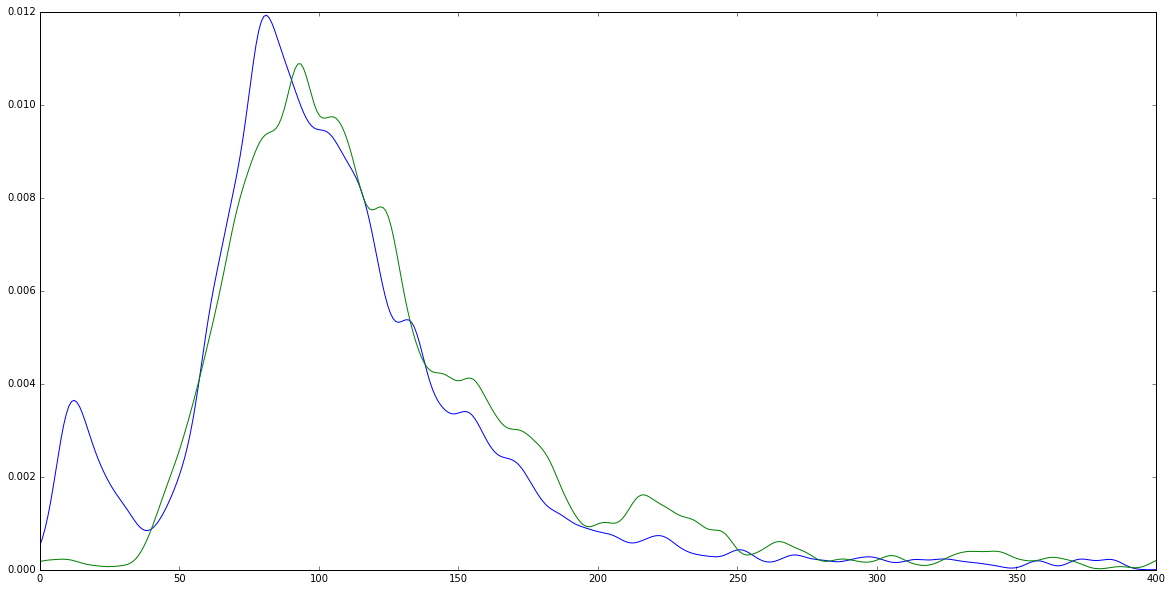

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

cf = 0.05

data = knn_errors
density = gaussian_kde(data)
xs = np.linspace(0,max(data),1000)
density.covariance_factor = lambda : cf
density._compute_covariance()
plt.plot(xs,density(xs))

data = stib_errors
density = gaussian_kde(data)
xs = np.linspace(0,max(data),1000)
density.covariance_factor = lambda : cf
density._compute_covariance()
plt.plot(xs,density(xs))

plt.xlim(0,400)

plt.show()

In [24]:
N = 400
m = min(max(stib_errors), max(knn_errors))
XRange, YRange = np.linspace(0, m, N), np.linspace(0, m, N)
XMat, YMat = np.meshgrid(XRange, YRange)

X, Y = map(np.ravel, [XMat, YMat])
kde = gaussian_kde([stib_errors, knn_errors])
kde_scalar_sigma = 4 # the smaller the bigger the are taken into account
kde.set_bandwidth(bw_method=kde.factor / kde_scalar_sigma)
Z = kde([X, Y])

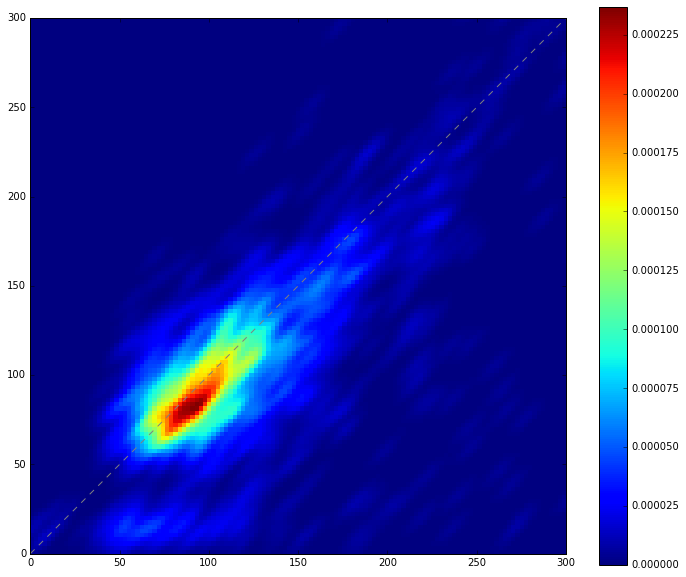

In [26]:
plt.figure(figsize=(12, 10))
plt.pcolor(XRange, YRange, Z.reshape(XMat.shape))
plt.xlim(0,300)
plt.ylim(0,300)
plt.plot([0, m], [0, m], linestyle="dashed", color="gray")
plt.colorbar()
plt.axes().set_aspect('equal', 'box');

In [28]:
from ipy_table import *

In [29]:
performances = [
    (scale, 100* len([(True) for s, k in zip(stib_errors, knn_errors) if (k * scale < s)]) / len(stib_errors))
    for scale in [1/2, 1/1.5, 1, 1.5, 2]
]
make_table(performances)

0.5,99.11864406779661
0.6666666666666666,95.05084745762711
1,63.389830508474574
1.5,17.966101694915253
2,11.525423728813559


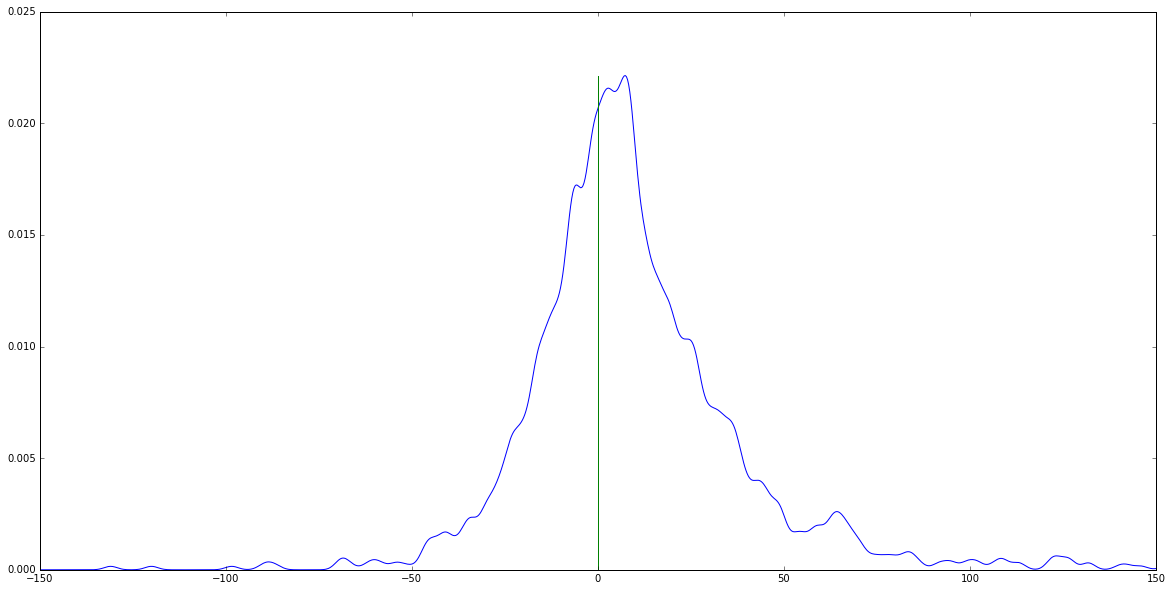

In [30]:
from math import cos, sin, pi
a = pi/4
data = [x * cos(a) - y * sin(a) for x,y in zip(stib_errors, knn_errors)]

cf = 0.05
density = gaussian_kde(data)
xs = np.linspace(-150, 150,1000)
density.covariance_factor = lambda : cf
density._compute_covariance()
plt.plot(xs,density(xs))
plt.plot([0, 0], [0, max(density(xs))])


plt.xlim(-150,150)

plt.show()